# KNN
This notebook contains the following parts:
* [Get Sample Data](#sampling)
* [Get Predictions & Evaluation](#modeling)
* [Recommendations & Evaluation](#rec)

In [1]:
import numpy as np
import pandas as pd

from datetime import date

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

from math import sqrt

In [2]:
#for timing process
import time

<a id='sampling'></a>
## Get Sample

In [9]:
## Note: csv_file is not included in the repo

def get_sample(csv_file, N, seed):
    np.random.seed(seed)
    ratings = pd.read_csv(csv_file)
    
    #keep only ratings from the most recent 5 years： 2010-2015
    ratings['year'] = ratings['timestamp'].apply(lambda x: date.fromtimestamp(x).year)
    ratings = ratings[ratings['year']>=date.fromisoformat('2010-01-01').year]
    ratings.drop(['timestamp','year'],axis=1,inplace=True) #'timestamp' and 'year' no longer useful 
    
    #keep only movies with at least 20 ratings
    m_counts = ratings.groupby('movieId').size()
    m_index = m_counts[m_counts>=20].index
    ratings = ratings[ratings['movieId'].isin(m_index)]
    
    #keep only users who have rated at least 20 movies - consistent with original data
    u_counts = ratings.groupby('userId').size()
    u_index = u_counts[u_counts>=20].index
    ratings = ratings[ratings['userId'].isin(u_index)]
    
    #sample out N users
    users = ratings['userId'].unique()
    u_index_sample = np.random.choice(users, N)
    sample = ratings[ratings['userId'].isin(u_index_sample)]
    
    #keep a percentage of ratings for each user: 30% -- lower variance
    pct = pd.DataFrame(columns=['userId','movieId','rating'])
    u_N, u_rating_count = np.unique(sample['userId'], return_counts=True)
    
    for i in range(len(u_N)):
        u_id = u_N[i]
        u_sample = sample[sample['userId']==u_id]
        u_sample = u_sample[u_sample['movieId'].isin(np.random.choice(u_sample['movieId'].unique(),
                                                                      int(u_rating_count[i]*0.3)))]
        pct = pct.append(u_sample)
    
    sample = pct
    
    print('number of unique users:', len(sample['userId'].unique()))
    print('number of unique movies:', len(sample['movieId'].unique()))
    
    return sample


In [3]:
sample = get_sample('ratings.csv', 1000, 1)

number of unique users: 974
number of unique movies: 5619


In [46]:
##Alternative Sampling
def get_sample_alt(csv_file, u_size, m_size, seed):
    np.random.seed(seed)
    sample = pd.read_csv(csv_file)
    
    #keep only ratings from the most recent 5 years： 2010-2015
    sample['year'] = sample['timestamp'].apply(lambda x: date.fromtimestamp(x).year)
    sample = sample[sample['year']>=date.fromisoformat('2010-01-01').year]
    sample.drop(['timestamp','year'],axis=1,inplace=True) #'timestamp' and 'year' no longer useful 
    
    #keep only movies with at least 20 ratings
    m_counts = sample.groupby('movieId').size()
    m_index = m_counts[m_counts>=20].index
    sample = sample[sample['movieId'].isin(m_index)]
    
    #keep only users who have rated at least 20 movies - consistent with original data
    u_counts = sample.groupby('userId').size()
    u_index = u_counts[u_counts>=20].index
    sample = sample[sample['userId'].isin(u_index)]
    
    #sample out u_size number of users and m_size number of movies
    user_sample = np.random.choice(sample.userId.unique(), replace=False, size=u_size)
    movie_sample = np.random.choice(sample.movieId.unique(), replace=False, size = m_size)
    sample = sample[sample['userId'].isin(user_sample)]
    sample = sample[sample['movieId'].isin(movie_sample)]
    
    #plot sample data
    plt.plot(np.arange(1, len(sample['userId'].unique())+1), sorted(sample.groupby('userId').size(), reverse=True))
    plt.xlabel('number of users')
    plt.ylabel('number of rated movies')
    plt.show()
   
    print('number of unique users:', len(sample['userId'].unique()))
    print('number of unique movies:', len(sample['movieId'].unique()))
    
    return sample

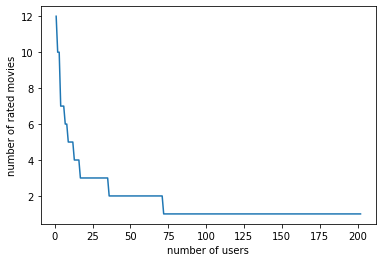

number of unique users: 202
number of unique movies: 35


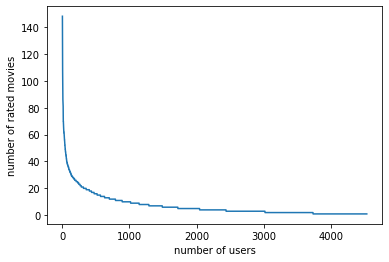

number of unique users: 4536
number of unique movies: 496


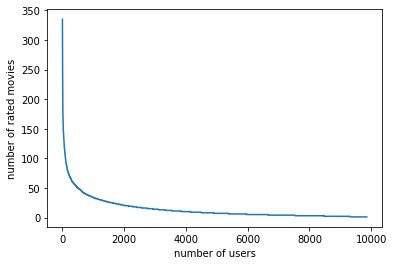

number of unique users: 9855
number of unique movies: 1000


In [47]:
#sample size of 500-100, 5000-500, 10000-1000
sample1 = get_sample_alt('ratings.csv', 500, 50, 1)
sample2 = get_sample_alt('ratings.csv', 5000, 500, 1)
sample3 = get_sample_alt('ratings.csv', 10000, 1000, 1)

In [3]:
def get_train_test(sample_data, split, seed):
    np.random.seed(seed)
    sample = sample_data
    
    train, test = train_test_split(sample, test_size=split)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    
    #check
    print('number of users in train:',len(np.unique(train['userId'])))
    print('number of movies in train:',len(np.unique(train['movieId'])))
    print('number of users in test:', len(np.unique(test['userId'])))
    print('number of movies in test:',len(np.unique(test['movieId'])))
    
    return train, test

In [6]:
train1, test1 = get_train_test(sample1,0.3,1)
train2, test2 = get_train_test(sample2,0.3,1)
train2, test2 = get_train_test(sample3,0.3,1)

number of users in train: 4222
number of movies in train: 490
number of users in test: 3211
number of movies in test: 450


<a id='modeling'></a>
## Models
* [Baselin](#baseline)
* [KNN](#knn) - user-based collaborative filtering
    * Parameters: K (best # of neighbors)
    * Evaluation by RMSE, Precision, Recall

<a id='baseline'></a>
### Baseline

In [124]:
def accuray(predict_results, method="all"):
    #compare rmse with mae
    
    def rmse(predict_results):
        length = 0
        _rmse_sum = 0
        for uid, iid, real_rating, pred_rating in predict_results:
            length += 1
            _rmse_sum += (pred_rating - real_rating) ** 2
        return round(np.sqrt(_rmse_sum / length), 4)

    def mae(predict_results):
        length = 0
        _mae_sum = 0
        for uid, iid, real_rating, pred_rating in predict_results:
            length += 1
            _mae_sum += abs(pred_rating - real_rating)
        return round(_mae_sum / length, 4)

    def rmse_mae(predict_results):
        length = 0
        _rmse_sum = 0
        _mae_sum = 0
        for uid, iid, real_rating, pred_rating in predict_results:
            length += 1
            _rmse_sum += (pred_rating - real_rating) ** 2
            _mae_sum += abs(pred_rating - real_rating)
        return round(np.sqrt(_rmse_sum / length), 4), round(_mae_sum / length, 4)

    if method.lower() == "rmse":
        rmse(predict_results)
    elif method.lower() == "mae":
        mae(predict_results)
    else:
        return rmse_mae(predict_results)

    
    
class BaselineCFBySGD(object):

    def __init__(self, number_epochs, alpha, reg, columns=["uid", "iid", "rating"]):
        self.number_epochs = number_epochs
        self.alpha = alpha
        self.reg = reg
        self.columns = columns

    def fit(self, dataset):
        self.dataset = dataset
        self.users_ratings = dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        self.items_ratings = dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]
        self.global_mean = self.dataset[self.columns[2]].mean()
        self.bu, self.bi = self.sgd()

    def sgd(self):
        bu = dict(zip(self.users_ratings.index, np.zeros(len(self.users_ratings))))
        bi = dict(zip(self.items_ratings.index, np.zeros(len(self.items_ratings))))
        for i in range(self.number_epochs):
            for uid, iid, real_rating in self.dataset.itertuples(index=False):
                error = real_rating - (self.global_mean + bu[uid] + bi[iid])
                bu[uid] += self.alpha * (error - self.reg * bu[uid])
                bi[iid] += self.alpha * (error - self.reg * bi[iid])
        return bu, bi

    def predict(self, uid, iid):
        if iid not in self.items_ratings.index:
            raise Exception("Cannot predict <{uid}>'s rating of <{iid}> because <{iid}> data is missing in training set".format(uid=uid, iid=iid))
        predict_rating = self.global_mean + self.bu[uid] + self.bi[iid]
        return predict_rating

    def test(self,testset):
        for uid, iid, real_rating in testset.itertuples(index=False):
            try:
                pred_rating = self.predict(uid, iid)
            except Exception as e:
                print(e)
            else:
                yield uid, iid, real_rating, pred_rating

if __name__ == '__main__':

    trainset = train
    testset = test

    bcf = BaselineCFBySGD(20, 0.1, 0.1, ["userId", "movieId", "rating"])
    bcf.fit(trainset)

    pred_results = bcf.test(train)

    rmse, mae = accuray(pred_results)

<a id='knn'></a>
### User-based CF: KNN

In [ ]:
# start=time.time()

In [7]:
def get_o_matrices(input_df):
    #create index
    users = np.unique(input_df['userId'])
    #transform dataframe to matrix
    ratings = input_df.pivot(index='userId',columns='movieId',values='rating').fillna(0)
    #calculate user pairwise similarity scores
    user_sim = cosine_similarity(ratings)
    user_sim = pd.DataFrame(user_sim, columns=users, index=users).fillna(0)
    return ratings, user_sim

In [8]:
def get_knn_sim(sim_matrix, k):
    df = sim_matrix.copy()
    for i in df.index:
        row = df.loc[i]
        row_sorted = row.sort_values(ascending=False)[0:(k+1)]
        row_sorted.loc[i]=0
        row_sorted[(k+1):]=0
        df.loc[i] = row_sorted

    df = df.fillna(0)
    return df

In [9]:
def get_normalized_ratings(original_ratings_matrix):
    df = original_ratings_matrix.copy()
    for i in df.index:
        o_row = df.loc[i]
        mean = np.mean(o_row[o_row>0])
        #if a user-movie pair has no rating, normalized rating should be 0
        bm = (o_row==0)
        o_row[bm] = mean
        df.loc[i] = o_row - mean
    return df

In [10]:
def mean_ratings(original_ratings_matrix):
    df = original_ratings_matrix.copy()
    for i in df.index:
        o_row = df.loc[i]
        mean = np.mean(o_row[o_row>0])
        bm = (o_row!=0)
        o_row[bm] = mean
    return df

In [11]:
#for movies already consumed - test the model
def get_prediction(sim_df, norm_ratings, u_mean_ratings):
    per_user_sim = np.sum(abs(sim_df),axis=1)

    predict_nomean = sim_df.dot(norm_ratings)
    predict_nomean = predict_nomean.apply(lambda x: x/per_user_sim)
    prediction = predict_nomean + u_mean_ratings
    
    return prediction

In [12]:
def get_rmse(prediction, input_df, original_ratings_matrix):
    N = prediction.shape[0]*prediction.shape[1]
    n = len(input_df)
    RMSE = sqrt(mean_squared_error(original_ratings_matrix, prediction.fillna(0))*N/n)
    return RMSE

<p style="color:red">When testing for best k, we cannot just run a loop from 0 to 60: takes too long</p>

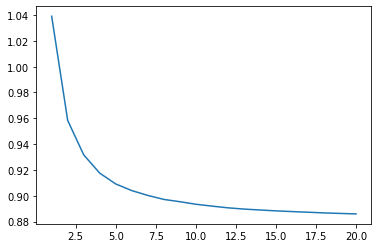

In [58]:
#也许可以用这个，但还是一个for loop会很慢
#visualize
# k_list = np.arange(1,21)
# score_list = np.array([])

# for k in k_list:
#     o_rat, o_sim = get_o_matrices(train)
#     knn = get_knn_sim(o_sim,k)
#     norm_ratings = get_normalized_ratings(o_rat)
#     mean_results = mean_ratings(o_rat)
#     predict = get_prediction(knn, norm_ratings, mean_results)
#     score = get_rmse(predict,train,o_rat)
#     score_list = np.append(score_list, score)

plt.plot(k_list, score_list)
plt.show()

In [122]:
##use training data to get the parameter: best k (neighbors)
o_rat, o_sim = get_o_matrices(train2)

def get_best_k(input_df):
    best_k = 0
    best_rmse = 10 #set one large enough
    for k in range(50,60):
        knn = get_knn_sim(o_sim,k)
        norm_ratings = get_normalized_ratings(o_rat)
        mean_results = mean_ratings(o_rat)
        predict = get_prediction(knn, norm_ratings, mean_results)
        rmse = get_rmse(predict,train,o_rat)
        if rmse < best_rmse:
            best_k = k
            best_score = score
    print('best k is:', best_k)
    print('best RMSE is:', best_score)
    
    return best_k

In [15]:
# best_k = 55
best_k = 51

def get_perf(input_df):
    o_rat, o_sim = get_o_matrices(input_df)
    knn = get_knn_sim(o_sim, best_k)
    norm_ratings = get_normalized_ratings(o_rat)
    mean_results = mean_ratings(o_rat)
    predict = get_prediction(knn, norm_ratings, mean_results)
    rmse = get_rmse(predict,input_df,o_rat)
    print('When k is', best_k, 'the RMSE is', rmse)
    return rmse

In [16]:
get_perf(train2)

When k is 51 the RMSE of test set is 0.7924332526483753


0.7924332526483753

In [17]:
get_perf(test2)

When k is 51 the RMSE of test set is 0.7334208260326935


0.7334208260326935

<a id='rec'></a>
## Recommendation Modeling
* Parameter for tuning: n = the number of _new_ movies to recommend to users
* [Generate Recommendations](#get-rec)
* [Evaluations](#eval)

<a id='get-rec'></a>
### Generate Recs

In [19]:
##create ratings df to rank and rec new movies on training data

o_rat, o_sim = get_o_matrices(train2)
knn = get_knn_sim(o_sim,best_k)

new_m_mask = o_rat.copy()
for i in new_m_mask.index:
    o_row = new_m_mask.loc[i]
    #if watched, discard. if unwatched, keep
    o_row[o_row>0] = 10
    o_row[o_row<=0] = 1
    o_row[o_row!=1] = 0

ratings_for_rec = (knn.dot(o_rat))*new_m_mask

In [20]:
##generate raw recommendations from training data
##see section: parameter tuning for tuning algorithm

n = 10 #arbitrary at the moment
rec = {}
for i in ratings_for_rec.index:
    row = ratings_for_rec.loc[i]
    row_sorted = row.sort_values(ascending=False)[0:n]
    m_ind = row_sorted.index
    rec[i] = list(m_ind)


In [23]:
#filter recommendations with testing data
watched = {}
for i in sorted(test2['userId'].unique()):
    movies = test2[test2['userId']==i]['movieId']
    watched[i] = list(movies)
watched_m = np.array(list(watched.values()))

watched_userid = list(watched.keys())
rec_userid = list(rec.keys())
keep={}
for key in rec_userid:
    if key in watched_userid:
        keep[key]=rec[key]

##final recommendations      
rec_m = np.array(list(keep.values()))

In [40]:
topn_rec = pd.DataFrame(rec_m)
topn_rec.index.name = 'userId'
topn_rec

,0,1,2,3,4,5,6,7,8,9
userId,,,,,,,,,,
0,2329,48780,150,1240,1682,70286,91500,8784,1228,428
1,2329,5669,1617,7438,72011,88125,4223,26614,8361,62956
2,48780,8361,70286,2329,7438,86347,26614,59784,1682,94864
3,69844,58156,922,4447,539,56079,6763,1682,95088,86298
4,196,61323,3082,8784,34150,72011,208,6870,1682,6218
...,...,...,...,...,...,...,...,...,...,...
2892,1682,1240,7438,1617,2329,72011,88125,3703,48780,3504
2893,70286,2329,7438,150,1617,61323,72011,434,3703,8361
2894,1240,70286,150,1682,1617,26614,88125,91500,69844,8371


<a id='eval'></a>
### Evaluations
* 1st layver: Precision & Recall
* 2nd layer: coverage

In [41]:
precision = 0
recall = 0
for i in range(0,len(rec_m)):
    R = set(rec_m[i])
    W = set(watched_m[i])
    u_precision = len(R.intersection(W))/len(R)
    u_recall = len(R.intersection(W))/len(W)
    
    precision += u_precision
    recall += u_recall
    
print('precision is', precision/len(watched_userid))
print('recall is', recall/len(watched_userid))

precision is 0.04493927125506009
recall is 0.16386601953107188


In [43]:
coverage = len(set(rec_m.flatten()))/len(np.unique(test2['movieId']))
coverage

0.7

### Parameter Tuning: n = number of new movies to recommend

In [44]:
#visualized
N_recommended_list = [5,10,15,20,25,30,35,40]
precision = []
recall = []
coverage = []
for n in N_recommended_list:
    for i in ratings_for_rec.index:
        row = ratings_for_rec.loc[i]
        row_sorted = row.sort_values(ascending=False)[0:n]
        m_ind = row_sorted.index
        rec[i] = list(m_ind)
        
        watched_userid = list(watched.keys())
        rec_userid = list(rec.keys())
        keep={}
        for key in rec_userid:
            if key in watched_userid:
                keep[key]=rec[key]

        rec_m = np.array(list(keep.values()))
        
    precision_ = 0
    recall_ = 0
    for i in range(0,len(rec_m)):
        R = set(rec_m[i])
        W = set(watched_m[i])
        u_precision = len(R.intersection(W))/len(R)
        u_recall = len(R.intersection(W))/len(W)
    
        precision_ += u_precision
        recall_ += u_recall
    
    precision.append(precision_/len(watched_userid))
    recall.append(recall_/len(watched_userid))
    #print('when n is:',n,'the precision is:',precision/len(watched_userid),'the recall is:', recall/len(watched_userid))
    #print('the recall is:', recall/len(watched_userid))
    coverage.append(len(set(rec_m.flatten()))/len(np.unique(test['movieId'])))
    #print('when n is:',n,'the precision is:',precision,'the recall is:', recall,'the coverage is:',coverage)

plt.figure(figsize=(10,5))
plt.plot(N_recommended_list,coverage,label='coverage')
plt.plot(N_recommended_list,recall,label='recall')
plt.plot(N_recommended_list,precision,label='precision')
plt.legend(loc='upper right', shadow=True, ncol=1)
plt.show()

KeyboardInterrupt: 

In [ ]:
end = time.time()
print(end-start)